In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
# from train_bbnet import get_args, load_model
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def zscore(x, eps=1e-6):
    m = x.mean((-2,-1), True)
    s = x.std((-2,-1), True)
    return (x - m) / s.clamp(min=eps)

def get_patches(im, radius=1):
    if radius == 0:
        return im
    shape = im.shape
    if len(shape) == 5:
        im = im.view(shape[0]*shape[1], *shape[2:])
    B,C,H,W = im.shape
    
    im = F.pad(im, (radius, radius, radius, radius))
    k = 2*radius+1
    im = F.unfold(im, (k, k)).view(-1,C*(k**2),H,W)
    if len(shape) == 5:
        im = im.view(shape[0], shape[1], *im.shape[1:])
    return im    
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = (aff_node.shape[-1] - 1) // 2
#     aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,(K+1):]], 1)        
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False, is_test=False, sigmoid=True):
    dataset.is_test = is_test
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = (nn.Sigmoid() if sigmoid else nn.Identity())(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  
    

def viz_boundary_preds(b_preds, thresh=0.1, max_speed=0.1, do_plot=True):
    motion = None
    if b_preds.shape[1] == 9:
        c1_preds, b_preds, c2_preds = b_preds.split([4,1,4], dim=-3)
        c_preds = torch.cat([c1_preds, c2_preds], -3).softmax(-3)
        c_preds_rgb = fprop.circular_target_to_spatial_moment(c_preds)
    elif b_preds.shape[1] == 3:
        b_preds, c_preds = b_preds.split([1,2], dim=-3)
        c_preds_rgb = c_preds
    elif b_preds.shape[1] == 4:
        motion, b_preds, c_preds = b_preds.split([1,1,2], dim=-3)
        c_preds_rgb = c_preds
    b_preds = b_preds.sigmoid()
    if do_plot:
        vis_utils.imshow(data_utils.FlowToRgb(max_speed=max_speed)(c_preds_rgb) * (b_preds > thresh).float())    
    return (b_preds, c_preds, motion)


def get_boundary_preds(model, dataset, ex, static_input=True, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]
    if backward:
        ups_mask, b_preds = model(img2, img2 if static_input else img1, test_mode=True, iters=iters)
    else:
        ups_mask, b_preds = model(img1, img1 if static_input else img2, test_mode=True, iters=iters)
    return (b_preds, ups_mask)

def get_motion_preds(model, dataset, ex, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]    
    if backward:
        ups_mask, m_preds = model(img2, img2, test_mode=True, iters=iters)
    else:
        ups_mask, m_preds = model(img1, img2, test_mode=True, iters=iters)
    return (m_preds, ups_mask)

def get_boundary_movie(model, dataset, ex, iters=12, thresh=None):
    img1, img2, img0 = [x[None].cuda() for x in dataset[ex][:3]]
    b1 = model(img1, img1, test_mode=True, iters=12)[-1]
    b2 = model(img2, img2, test_mode=True, iters=12)[-1]
    b0 = model(img0, img0, test_mode=True, iters=12)[-1]
    b_movie = []
    for b in [b0, b1, b2]:
        b_preds, c_preds = viz_boundary_preds(b, do_plot=False)
        if thresh is not None:
            b_movie.append((b_preds > thresh).float() * c_preds)
        else:
            b_movie.append(b_preds * c_preds)
    return torch.stack(b_movie, 1)

def get_video(dataset, ex=0, stride=1):
    dataset.get_backward_frame = True
    data = dataset[ex]
    video = torch.stack([x.cuda() for x in [data[2], data[0], data[1]]], 0) / 255.
    size = list(video.shape[-2:])
    if stride > 1:
        video = transforms.Resize((size[0] // stride, size[1] // stride))(video)
    return video[None]


/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py:546: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class IteratorBase(collections.Iterator, trackable.Trackable,
/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:106: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class DatasetV2(collections.Iterable, tracking_base.Trackable,
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resource

In [4]:
def get_gt_motion_and_boundaries(dataset, ex, max_objects=8, radius=3):
    dataset.get_backward_frame = False
    dataset.get_gt_segments = True
    dataset.get_gt_flow = True    
    
    img1, img2, flow, segments = [x[None].cuda() for x in dataset[ex]]
    motion = (flow.abs().sum(1, True) > 0).float()
    obj_ids = torch.unique(segments)[:max_objects]
    masks = (segments == obj_ids.view(1, -1, 1, 1)).float()
    borders, _ = fprop.get_mask_boundaries(masks)
    masks, borders = masks[:,1:], borders[:,1:]
    size = masks.shape[-2:]
    orients = fprop.estimate_boundary_orientations(
        borders.view(-1, 1, *size),
        masks.view(-1, 1, *size),
        radius=radius,
        to_circle=False
    ).view(1, -1, 2, *size)
    return (img1, flow, motion, masks, borders, orients)

def mask_orientations(masks, boundaries, orientations):
    return (orientations * boundaries[:,:,None] * masks[:,:,None]).sum(1)

def get_adj_gt(masks, radius=3):
    masks = torch.cat([1-masks.amax(1, True), masks], -3)
    segments = masks.argmax(1, True)
    adj_gt = fprop.get_local_neighbors(
        segments, radius=radius, to_image=True, invalid=-1
    )[:,0] == segments
    return adj_gt.float()

def estimate_kp_adj(motion, boundaries, radius=3):
    r = radius
    k = 2*r + 1
    K = k**2
    null_idx = (K - 1) // 2
    B,_,H,W = motion.shape
    adj = F.one_hot(torch.tensor(null_idx), num_classes=K).to(motion.device)
    adj = adj.view(1,1,k,k).repeat(B*H*W, 1, 1, 1)
    mask = fprop.get_local_neighbors(motion, radius=r, invalid=0, to_image=True)[:,0]
    mask = mask.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    adj = adj * mask
    boundaries = fprop.get_local_neighbors(boundaries, radius=r, invalid=0, to_image=True)[:,0]
    b = boundaries.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    
#     u = 1 - adj
    kernel = torch.ones((3,3)).float().view(1,9,1,1).repeat(1,1,k,k).to(b.device)
    
    for it in range(r):
        adj_new = fprop.compute_local_effects(adj, kernel)
#         u = F.relu(u - fprop.compute_local_effects(adj.abs(), kernel))
        adj_new = adj_new * (1 - b) - adj_new.abs() * b
        adj = (adj + adj_new).clamp(min=-1, max=1) * mask        
    adj = F.relu(adj)
    adj = adj.view(B,H*W,K).permute(0,2,1).view(B,K,H,W)
    adj = torch.maximum(adj, boundaries) * motion
    return adj

import matplotlib
def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

# ex = 21
# _img, _flow, _motion, _masks, _borders, _orients = get_gt_motion_and_boundaries(tdw_dataset, ex)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(5)],
    split='validation',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)


data_dir = '/mnt/fs6/honglinc/dataset/tensorflow_datasets/movi_d/256x256/1.0.0'
movi_dataset = raft_datasets.MoviFlowDataset(
    root=data_dir,
    split='validation',
    sequence_length=2
)
print(len(movi_dataset))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


625
True
250


# Look at TargetFunc outputs

In [7]:
# motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*nthr05*fullplay*pretrained*
# motion_paths = !ls ../checkpoints/[0-9]*motion*tdw*nthr0-cthr025*
motion_paths = !ls ../checkpoints/[0-9]*motion*movi_d*nthr0-*gs1*1*

motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/2500_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
1 ../checkpoints/5000_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
2 ../checkpoints/7500_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
3 ../checkpoints/10000_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
4 ../checkpoints/12500_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
5 ../checkpoints/15000_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
6 ../checkpoints/17500_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
7 ../checkpoints/20000_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
8 ../checkpoints/22500_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
9 ../checkpoints/25000_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
10 ../checkpoints/27500_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
11 ../checkpoints/30000_motion-rnd0-movi_d-bs4-large-dta

In [8]:
# boundary_paths = !ls ../checkpoints/[0-9]*boundary*rnd1*dtarg*fullplay*pretrained*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*cthr075*fullplay*rerun*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*small*nthr0*cthr075*fullplay*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*large*nthr0*fullplay*

boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotion*rnd0*movi_d*nthr0-*gs1*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStatic*rnd0*movi_d*nthr0-*gs1*

boundary_paths = sorted(boundary_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
for i,p in enumerate(boundary_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/2500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-0.pth
1 ../checkpoints/2500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-1.pth
2 ../checkpoints/2500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-2.pth
3 ../checkpoints/2500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-3.pth
4 ../checkpoints/5000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-0.pth
5 ../checkpoints/5000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-1.pth
6 ../checkpoints/5000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-2.pth
7 ../checkpoints/5000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-3.pth
8 ../checkpoints/7500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-0.pth
9 ../checkpoints/7500_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-1.pth
10 ../checkpoints/7500_boundaryMotionReg

In [9]:
flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*movi_d*gs1*
# flow_paths = !ls ../checkpoints/[0-9]*flow*tdw*

flow_paths = sorted(flow_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(flow_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/2500_flowBoundary-bmt-rnd0-movi_d-bs2-large-mt05-bt01-gs1-0.pth
1 ../checkpoints/2500_flowBoundary-bmt-rnd0-movi_d-bs2-large-mt05-bt05-gs1-0.pth
2 ../checkpoints/2500_flowBoundary-rnd0-movi_d-bs2-large-gs1-0.pth
3 ../checkpoints/5000_flowBoundary-bmt-rnd0-movi_d-bs2-large-mt05-bt01-gs1-0.pth
4 ../checkpoints/5000_flowBoundary-bmt-rnd0-movi_d-bs2-large-mt05-bt05-gs1-0.pth
5 ../checkpoints/5000_flowBoundary-rnd0-movi_d-bs2-large-gs1-0.pth
6 ../checkpoints/7500_flowBoundary-bmt-rnd0-movi_d-bs2-large-mt05-bt01-gs1-0.pth
7 ../checkpoints/7500_flowBoundary-bmt-rnd0-movi_d-bs2-large-mt05-bt05-gs1-0.pth
8 ../checkpoints/7500_flowBoundary-rnd0-movi_d-bs2-large-gs1-0.pth
9 ../checkpoints/10000_flowBoundary-bmt-rnd0-movi_d-bs2-large-mt05-bt05-gs1-0.pth
10 ../checkpoints/10000_flowBoundary-rnd0-movi_d-bs2-large-gs1-0.pth
11 ../checkpoints/12500_flowBoundary-bmt-rnd0-movi_d-bs2-large-mt05-bt05-gs1-0.pth
12 ../checkpoints/12500_flowBoundary-rnd0-movi_d-bs2-large-gs1-0.pth
13 ../chec

In [10]:
import teachers
m_idx = -1
b_idx = -1
f_idx = 8
m_path = motion_paths[m_idx]
b_path = boundary_paths[b_idx]
f_path = flow_paths[f_idx]
# f_path = None

TargetFunc = teachers.MotionToStaticTeacher(
    downsample_factor=2,
    motion_resolution=None,
    target_from_motion=False,
    return_intermediates=True,
    motion_path=m_path,
    boundary_path=b_path,
    flow_path=f_path,
    motion_model_params={
        'small': 'small' in m_path,
        'gate_stride': 2 if ('gs1' not in m_path) else 1
    },
    boundary_model_params={
        'small': 'small' in b_path,
        'static_input': 'Static' in b_path,
        'orientation_type': 'regression',
        'gate_stride': 2 if ('gs1' not in b_path) else 1
    },
    target_model_params={
        'diffusion_params': None,
        'fp_params': {
            'num_iters': 1000,
            'resolution': 8,
            'radius': 5
        }
    }
).cuda()
TargetFunc.eval()

def plot_targets(model, dataset, ex, motion_thresh=0.5, boundary_thresh=0.1, **kwargs):
    img1, img2, flow, segments = [x[None].cuda() for x in dataset[ex]]
    model.target_model.motion_thresh = motion_thresh
    model.target_model.boundary_thresh = boundary_thresh
    targets = model(img1, img2, **kwargs)
    m_mask = (targets['motion'] > model.target_model.motion_thresh).float()
    b_mask = (targets['boundaries'] > model.target_model.boundary_thresh).float()
    
    model.target_model.FP.compute_kp_args = False
    fire = model.target_model.FP(
        motion=targets['motion'],
        boundaries=targets['boundaries'],
        orientations=targets['orientations'],
        adj=None
    )
    model.target_model.FP.compute_kp_args = True
    print(fire[0].shape)    
    targets['fire'] = fire
    
    fig, axes = plt.subplots(2,4,figsize=(16,8))
    n_r, n_c = len(axes[:,0]), len(axes[0])
    plots = [
        img1 / 255.,
        targets['motion']*2 - 1,
        targets['boundaries']*2-1,
        data_utils.FlowToRgb(0.25)(targets['orientations'] * b_mask * m_mask),
        targets['fire'] * 2 - 1,        
        targets['target'][:,None],
    ]
    cmaps = [None, 'inferno', 'RdBu_r', None, 'magma', 'twilight', None, 'twilight']
    print("target shape", plots[-1].shape)

    if flow is not None and (flow.shape[1] == 2):
        plots.append(torch.tensor(flow_to_rgb(flow[0].cpu().permute(1,2,0).numpy())).permute(2,0,1)[None])
    else:
        plots.append(torch.zeros_like(targets['target'][None]))
        
    if segments is not None:
        plots.append(segments.long() - 1)
    else:
        plots.append(torch.zeros_like(targets['target'][None]))
        
    for i in range(n_r):
        for j in range(n_c):
            ax = axes[i][j]
            plot = plots[i*n_c + j]
            cmap = cmaps[i*n_c + j]
            vis_utils.imshow(plot, ax, cmap=cmap, vmin=-1, vmax=plot.amax()+(1 if cmap == 'twilight' else 0))
            ax.set_xticks([])
            ax.set_yticks([])
    plt.tight_layout()
    plt.show()
    
    return targets

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier ../checkpoints/32500_motion-rnd0-movi_d-bs4-large-dtarg-nthr0-cthr025-pr1-gs1-1.pth
<All keys matched successfully> BoundaryClassifier ../checkpoints/100000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-3.pth
<All keys matched successfully> RAFT ../checkpoints/7500_flowBoundary-rnd0-movi_d-bs2-large-gs1-0.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


movie, frame b'3835' 21
updated with fire torch.Size([1, 121, 128, 128])


torch.Size([1, 256, 256])
target shape torch.Size([1, 1, 128, 128])


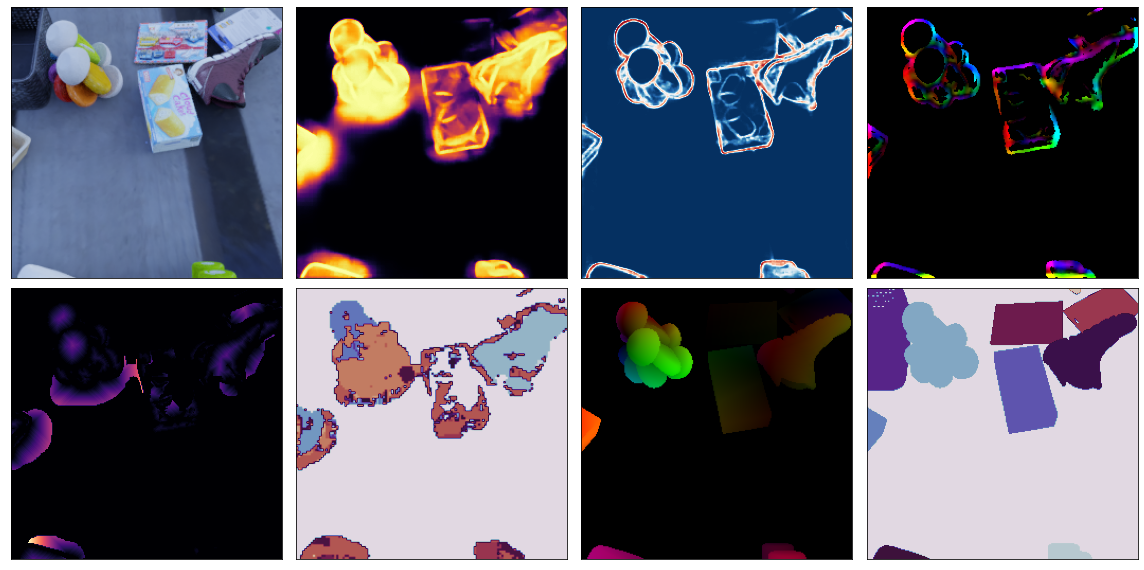

In [11]:
ex = 2

tdw_dataset.is_test = True
tdw_dataset.get_gt_flow = True
tdw_dataset.get_gt_segments = True
tdw_dataset.get_backward_frame = False
movi_dataset.T = 2
dataset = movi_dataset

targets = plot_targets(TargetFunc, dataset, ex=ex, motion_thresh=0.5, boundary_thresh=0.1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


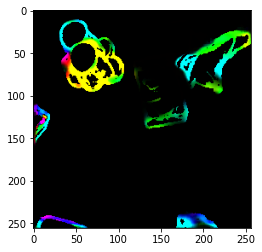

In [13]:
vis_utils.imshow(data_utils.FlowToRgb(1.0)(targets['flow']) *\
                 (targets['boundaries'] > 0.1).float())

## Debug BorderOwnership RNN

In [18]:
BO = fprop.BorderOwnership(num_iters=10, 
                           initial_diffusion_iters=2000,
                           diffusion_iters=5,
                           radius=5, 
                           downsample_factor=1,
                           motion_thresh=None,
                           boundary_thresh=0.1
).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


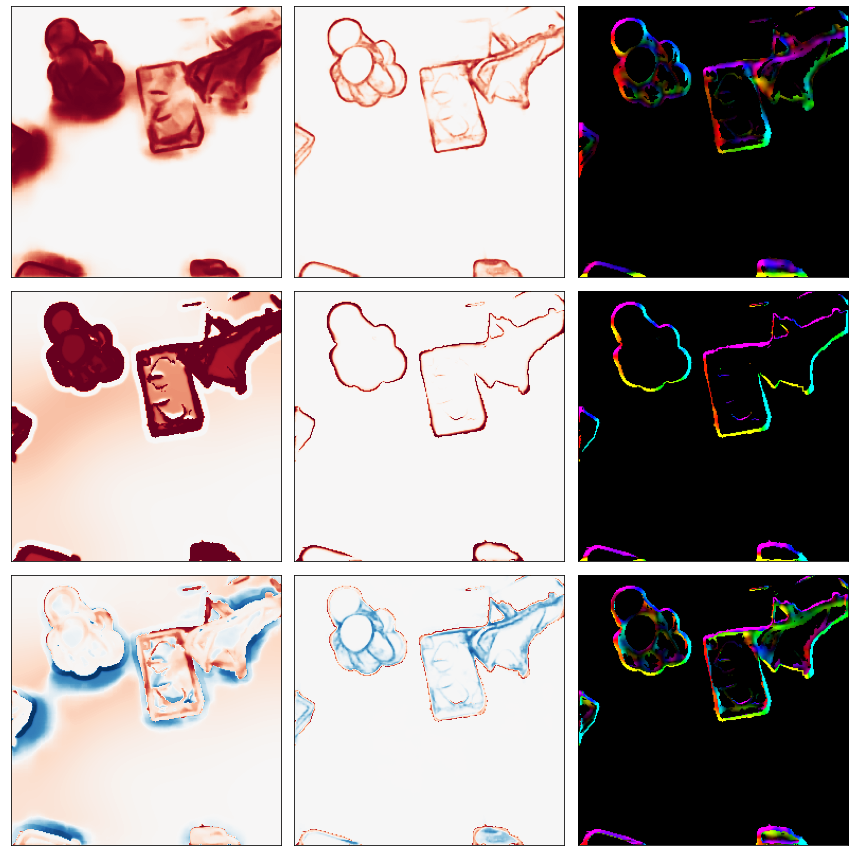

In [40]:
a0, b0, c0 = targets['motion'].detach(), targets['boundaries'].detach(), targets['orientations'].detach()
c0 = c0 * (b0 > 0.1).float()
a, b, c = BO(a0, b0, c0)
c = c * (b > 0.1).float()

fig, axes = plt.subplots(3,3,figsize=(12,12))

plot_kwargs = {
    0: {'cmap': 'RdBu_r', 'vmin': -1, 'vmax': 1},
    1: {'cmap': 'RdBu_r', 'vmin': -1, 'vmax': 1},
    2: {}
}

for i,plot in enumerate((a0, b0, c0)):
    if i == 1:
        plot = plot
    if i == 2:
        plot = data_utils.FlowToRgb(0.25)(plot)
    vis_utils.imshow(plot, axes[0,i], **plot_kwargs[i])
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
for i,plot in enumerate((a, b, c)):
    if i == 1:
        plot = plot
    if i == 2:
        plot = data_utils.FlowToRgb(0.25)(plot)
    vis_utils.imshow(plot, axes[1,i], **plot_kwargs[i])
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])    
for i,plot in enumerate((a-a0, b-b0, c-c0)):
    if i == 1:
        plot = plot
    if i == 2:
        plot = data_utils.FlowToRgb(0.25)(plot)    
    vis_utils.imshow(plot, axes[2,i], **plot_kwargs[i])
    axes[2,i].set_xticks([])
    axes[2,i].set_yticks([])
plt.tight_layout()
plt.show()


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


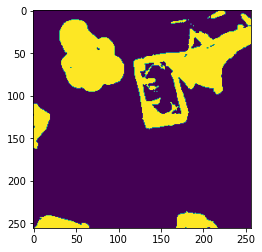

In [41]:
vis_utils.imshow(a > 0.5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


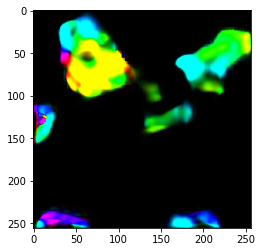

In [42]:
vis_utils.imshow(data_utils.FlowToRgb(1.0)(targets['flow']))

In [97]:
fpred = targets['flow']
bm = (b0 > 0.1).float()
flow_diffuse_h = BO.diffusion((1-bm)*fpred[:,0:1], bm, c0,
                            num_iters=1000,
                            a_thresh=None, b_thresh=0.1,
                            with_flux=False)
flow_diffuse_w = BO.diffusion((1-bm)*fpred[:,1:2], bm, c0,
                              num_iters=1000,
                              a_thresh=None, b_thresh=0.1,
                              with_flux=False)
flow_diffuse = torch.cat([flow_diffuse_h, flow_diffuse_w], 1)
flow_diffuse = flow_diffuse*(1-bm) + fpred*bm

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


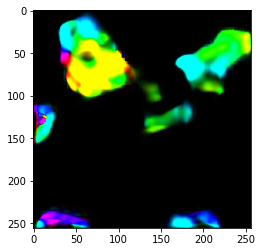

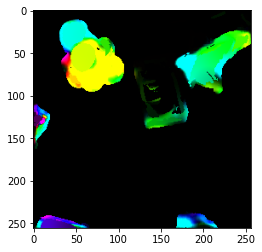

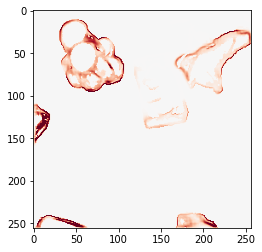

In [116]:
# vis_utils.imshow(fpred[:,0:1]*(1-bm), cmap='RdBu_r', vmin=-1, vmax=1)
# vis_utils.imshow(flow_diffuse, cmap='RdBu_r', vmin=-1, vmax=1)
flow_diffuse = BO.flow_diffusion_target(fpred.detach(), a, b0, 400)
am = (a > 0.5).float()
flow_edges = kornia.filters.SpatialGradient(mode='sobel')(fpred*a)
flow_edges = flow_edges.square().sum(2).sqrt().sum(1, True)

vis_utils.imshow(data_utils.FlowToRgb(1.)(fpred))
vis_utils.imshow(data_utils.FlowToRgb(1.)(flow_diffuse))
vis_utils.imshow(flow_edges*bm, cmap='RdBu_r', vmin=-1, vmax=1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


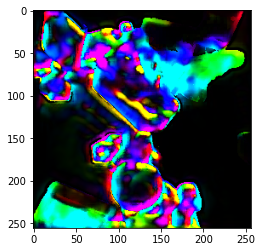

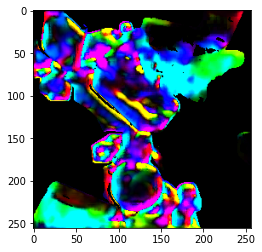

In [27]:
vis_utils.imshow(a * data_utils.FlowToRgb(1.0)(targets['flow']))
vis_utils.imshow((a>0.5).float() * data_utils.FlowToRgb(1.0)(targets['flow']))

In [ ]:
FP = fprop.FirePropagation().cuda()
MST = fprop.MotionSegmentTarget(downsample_factor=2, 
                                diffusion_params=None, 
                                fp_params={
                                    'num_iters': 2,
                                    'resolution': 4,
                                    'num_sample_points': 256
                                }
).cuda()
target = MST(None, a, b, c)
target.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


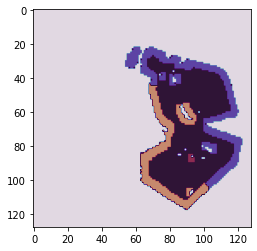

In [399]:
vis_utils.imshow(target[:,None], cmap='twilight', vmin=-1, vmax=target.amax().item()+1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


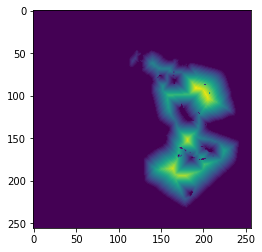

In [372]:
vis_utils.imshow(fire)

## Debug Flow

In [415]:
movi_dataset.T = 2
img1, img2, flow, segments = [x[None].cuda() for x in movi_dataset[ex]]
flow_pred, _ = TargetFunc.get_flow_preds(TargetFunc.flow_model, img1, img2, iters=12)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


movie, frame b'6657' 9


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


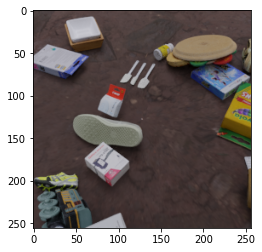

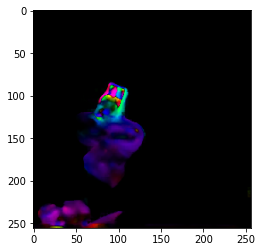

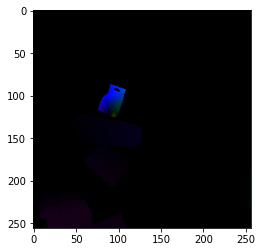

In [418]:
vis_utils.imshow(img1 / 255.)
vis_utils.imshow(data_utils.FlowToRgb(3.0)(flow_pred))
vis_utils.imshow(data_utils.FlowToRgb(20.)(flow))

# Look at targets on MOVi

In [9]:
data_dir = '/mnt/fs6/honglinc/dataset/tensorflow_datasets/movi_e/256x256/1.0.0'
movi_dataset = raft_datasets.MoviFlowDataset(
    root=data_dir,
    split='validation',
    sequence_length=2
)

movi_loader = torch.utils.data.DataLoader(movi_dataset, batch_size=1, shuffle=True)
print(len(movi_loader))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


250


In [446]:
[v.shape for v in iter(movi_loader).next()]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 1, 256, 256])]

In [443]:
seen = []
for i_batch in range(10):
#     if (i_batch % len(movi_loader) == 0):
#         movi_loader.dataset.reset()
    try:
        data = iter(movi_loader).next()
    except StopIteration:
        movi_loader.dataset.reset_iterator()
        data = iter(movi_loader).next()
        
    print(i_batch, movi_loader.dataset.meta['video_name'], movi_loader.dataset.frame)
    seen.append(movi_loader.dataset.meta['video_name'])
# print("example", movi_loader.dataset.meta['video_name'])
# for v in data:
#     print(v.shape, v.dtype, v.amax())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 b'1775' 10
1 b'6564' 9
2 b'5047' 6
3 b'3470' 0
4 b'9060' 1
5 b'3027' 11
6 b'6300' 21
7 b'7410' 5
8 b'9701' 14
9 b'3528' 7


In [444]:
len(set(seen))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10

In [377]:
img1, img2 = data[:2]
target = TargetFunc(img1.cuda(), img2.cuda())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


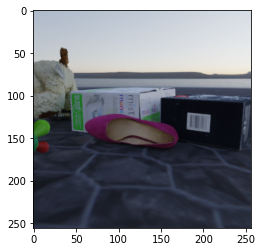

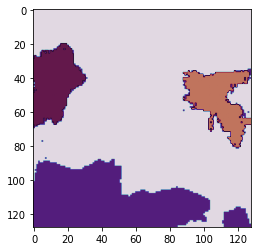

In [378]:
vis_utils.imshow(img1 / 255.)
vis_utils.imshow(target[None], cmap='twilight', vmin=-1, vmax=target.amax().item()+1)

In [384]:
mo, _ = TargetFunc.get_motion_preds(TargetFunc.motion_model, img1.cuda(), img2.cuda())
bo, co, _, _ = TargetFunc.get_boundary_preds(TargetFunc.boundary_model, img1.cuda(), img2.cuda())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


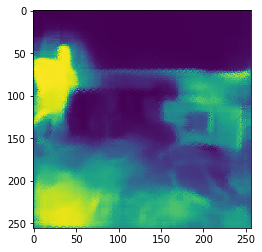

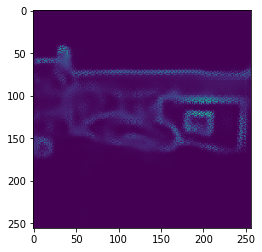

In [385]:
vis_utils.imshow(mo)
vis_utils.imshow(bo)